In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

def printmd(string):
    display(Markdown(string))

In [3]:
trainpaths = os.listdir("fingers/train")
testpaths = os.listdir("fingers/test")

train_str = "fingers/train/"
trainpaths = ["fingers/train/" + p for p in trainpaths]

test_str = "fingers/test/"
testpaths = ["fingers/test/" + p for p in testpaths]

df_train = pd.DataFrame(trainpaths, columns=['Filepath'])
df_train['set'] = 'train'

df_test = pd.DataFrame(testpaths, columns=['Filepath'])
df_test['set'] = 'test'

image_df = pd.concat([df_train,df_test])
image_df.reset_index(drop = True, inplace = True)

image_df.head(5)

,Filepath,set
0,fingers/train/00048bba-979b-4f84-b833-5bbbb082...,train
1,fingers/train/000547a2-d456-4b16-b351-12ca9b40...,train
2,fingers/train/000cac8e-fcf0-4f8c-bd16-c257d1e6...,train
3,fingers/train/000d9961-8136-4dee-9820-86e17877...,train
4,fingers/train/0010095b-2e3d-4517-a511-1f688c37...,train


In [4]:
image_df['Label'] = image_df['Filepath'].apply(lambda x: x[-6])

image_df['Label_LR'] = image_df['Filepath'].apply(lambda x: x[-5])

image_df = image_df.sample(frac=1,random_state=0)

image_df.head(5)

,Filepath,set,Label,Label_LR
641,fingers/train/08e35ceb-f05b-4e91-9f76-90a62132...,train,5,R
14864,fingers/train/d4371a5c-d1f0-4b5a-b74d-49a7a25e...,train,0,R
19127,fingers/test/4f0afad9-e205-4219-b35b-0f8c3b808...,test,2,R
4202,fingers/train/3a28fe35-2202-4712-8f53-b6324e85...,train,4,R
8524,fingers/train/77f4fc88-afaf-4aca-b005-d089eab3...,train,3,L


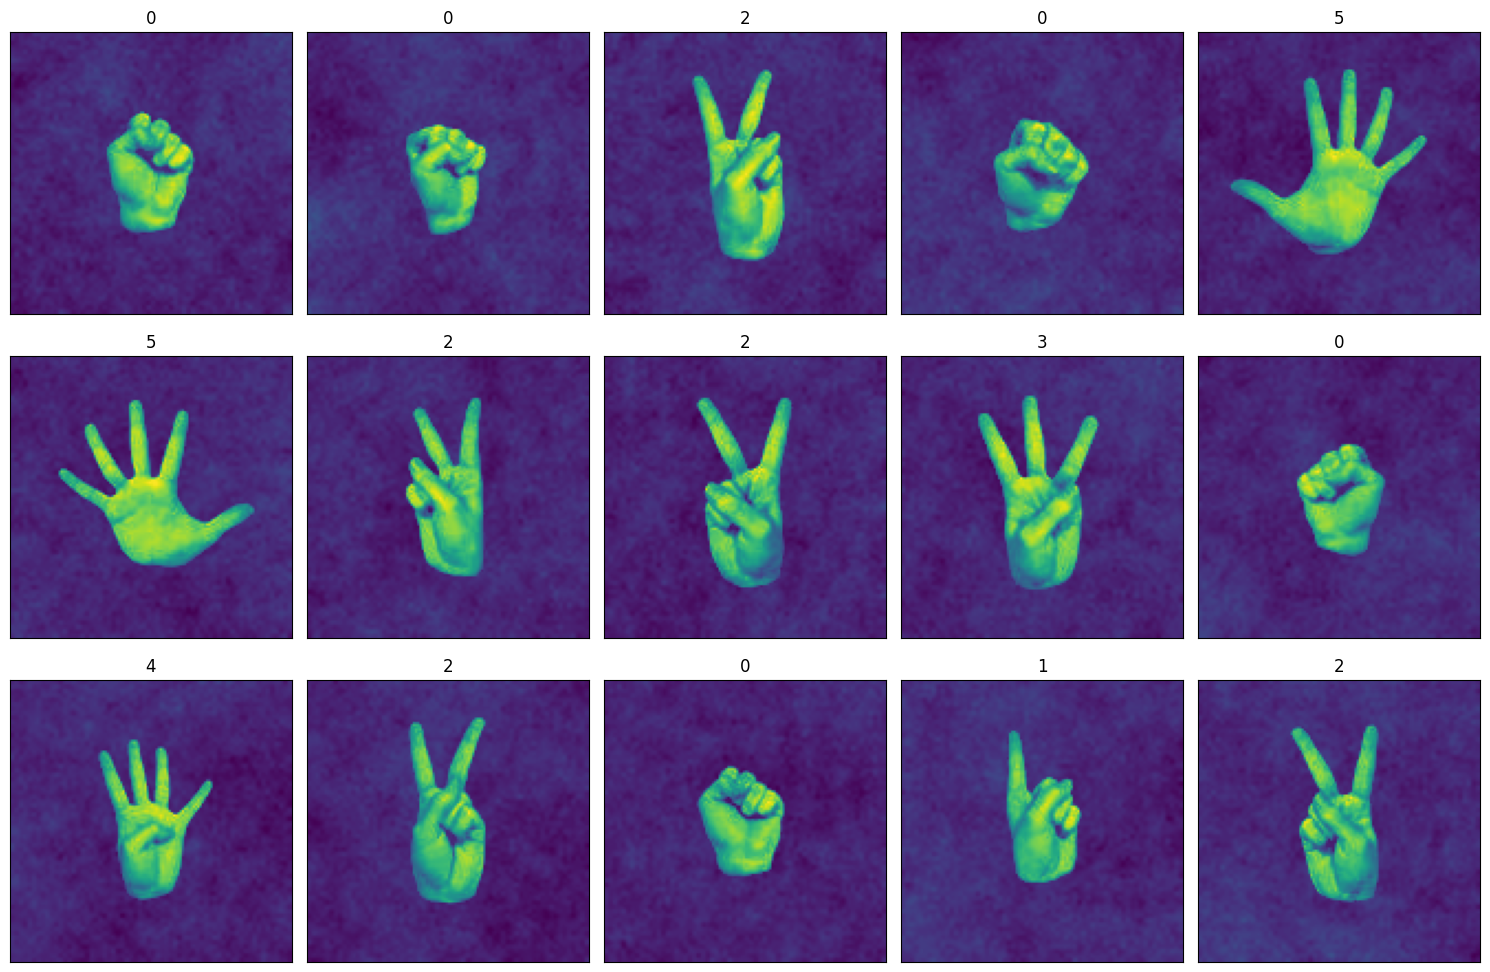

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df['Filepath'][i]))
    ax.set_title(image_df['Label'][i])
plt.tight_layout()
plt.show()

In [8]:
train_df = image_df[image_df['set']=='train']
test_df = image_df[image_df['set'] =='test'] 

In [9]:
train_df.head()

,Filepath,set,Label,Label_LR
641,fingers/train/08e35ceb-f05b-4e91-9f76-90a62132...,train,5,R
14864,fingers/train/d4371a5c-d1f0-4b5a-b74d-49a7a25e...,train,0,R
4202,fingers/train/3a28fe35-2202-4712-8f53-b6324e85...,train,4,R
8524,fingers/train/77f4fc88-afaf-4aca-b005-d089eab3...,train,3,L
12589,fingers/train/b3827398-3898-4cb2-8767-b9f8e460...,train,0,R


In [10]:
test_df.head()

,Filepath,set,Label,Label_LR
19127,fingers/test/4f0afad9-e205-4219-b35b-0f8c3b808...,test,2,R
18927,fingers/test/40c68e84-07a1-4c52-97b1-09acc403e...,test,0,R
19271,fingers/test/5a6068c8-9aee-4af5-a5e0-03f7869ee...,test,4,R
18475,fingers/test/1f0308d3-ae8d-4a32-a650-63ccef394...,test,5,R
19966,fingers/test/8c1153d0-fcec-40e8-ba77-2c466d879...,test,1,R


In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30, 
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30, 
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

Found 14400 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [19]:
inputs = pretrained_model.input
inputs

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_310>

In [25]:
x = tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128,activation='relu')(x)

outputs = tf.keras.layers.Dense(6,activation='softmax')(x) 

model = tf.keras.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,238 (9.30 MB)

 Trainable params: 181,254 (708.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(train_images,
                   validation_data=val_images,batch_size=32,epochs=2)

Epoch 1/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.9465 - loss: 0.1662 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 2/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9997 - val_loss: 5.9589e-04


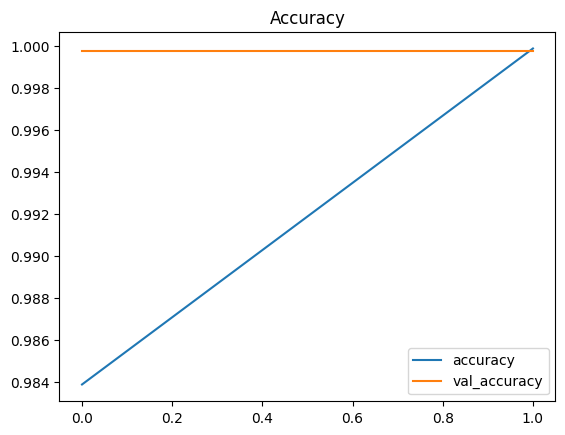

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

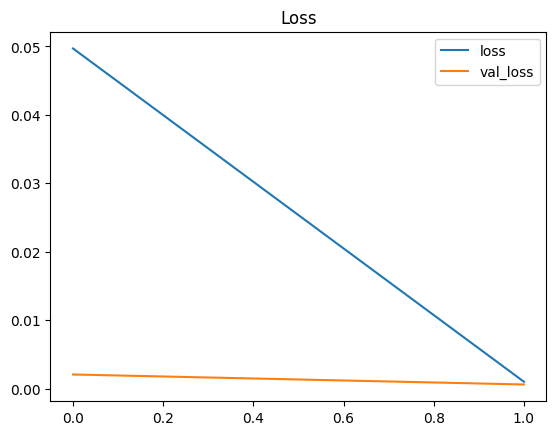

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [33]:
results = model.evaluate(test_images)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 1.0000 - loss: 4.7161e-04


In [31]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.00055

## Accuracy on the test set: 100.00%

In [36]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step


In [37]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



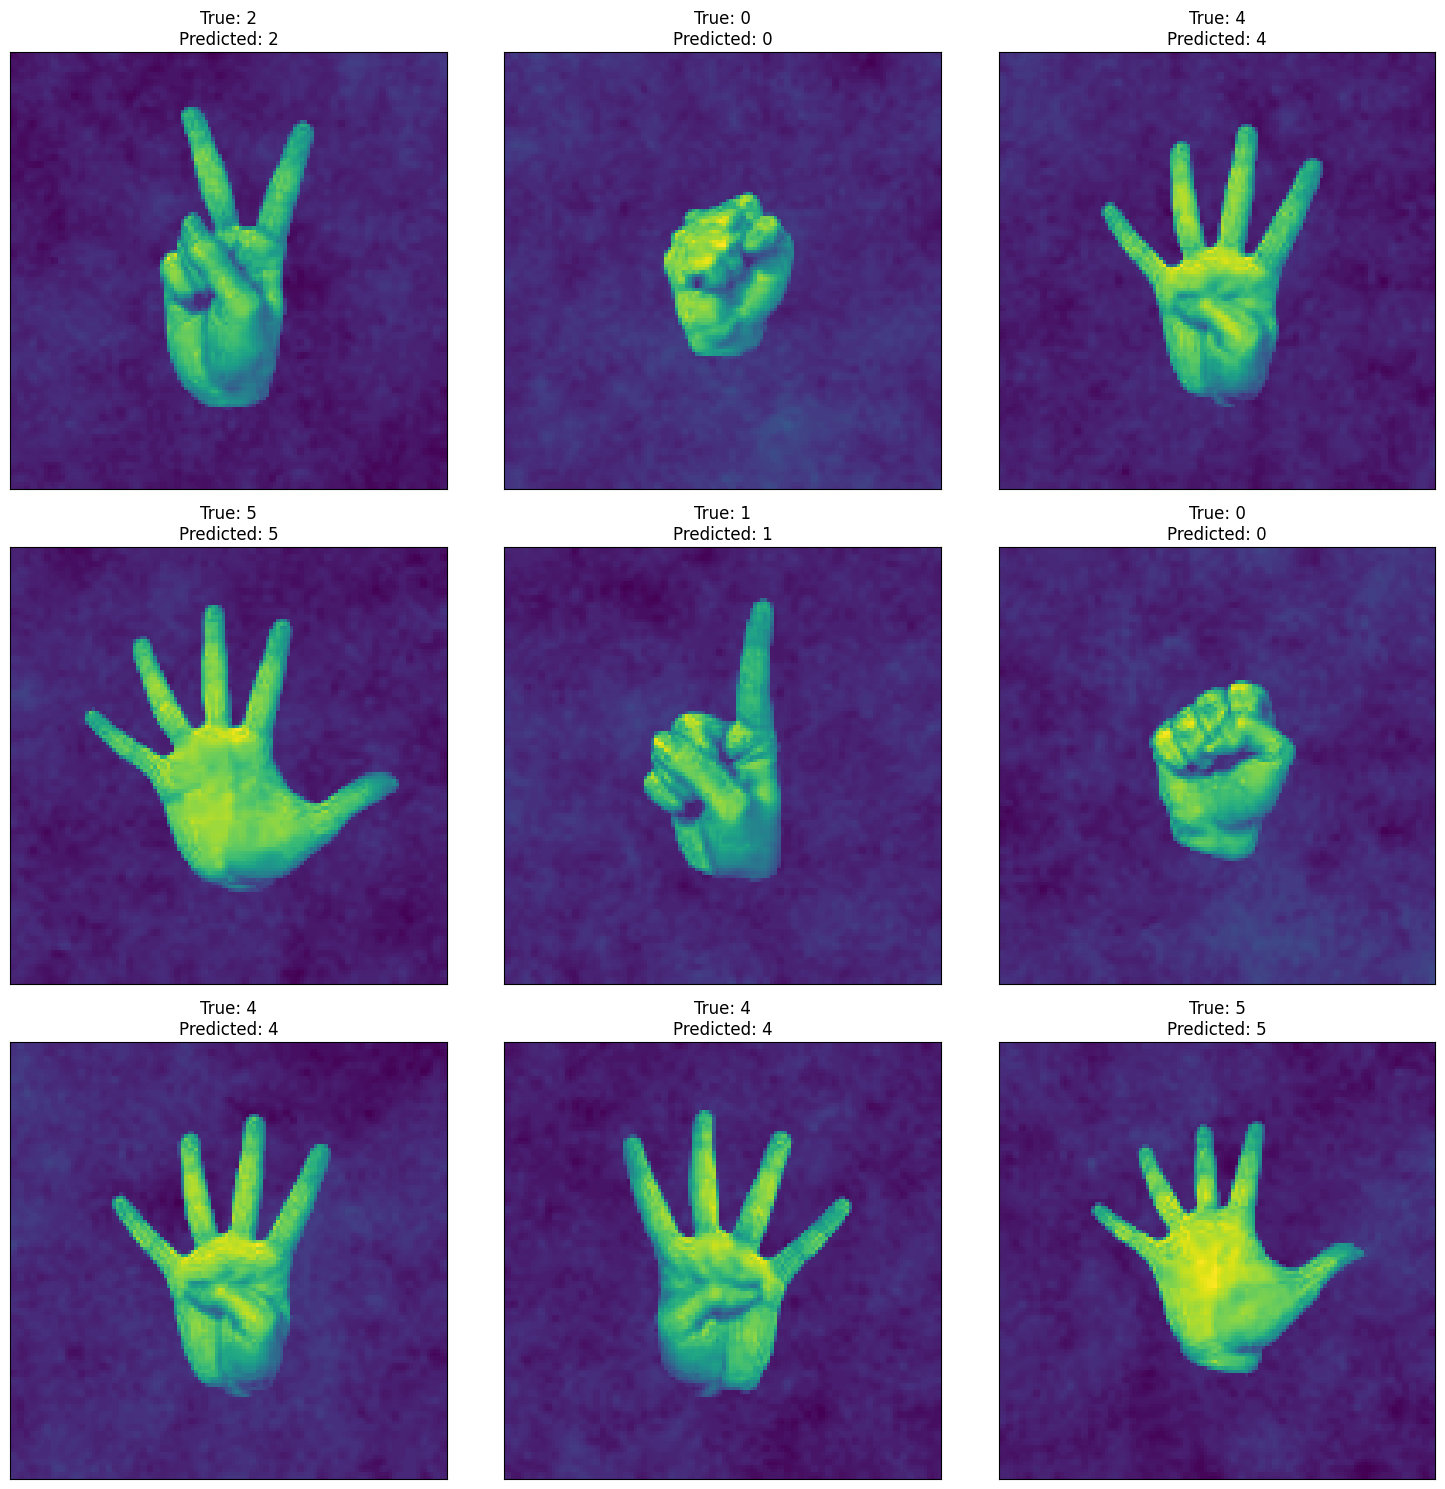

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

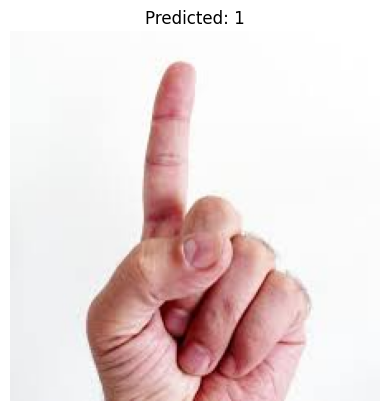

In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_path = 'images.jpg'
image = Image.open(image_path).resize((224, 224)).convert('RGB')
image_array = np.array(image) / 255.0  
image_array = np.expand_dims(image_array, axis=0)  

predictions = model.predict(image_array,verbose=0)

pred = np.argmax(predictions, axis=1)

labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items()) 
pred_labels = [labels[k] for k in pred]

predicted_class_label = pred_labels[0]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')  
plt.show()

In [51]:
model.save('model.keras')